# Time-dependent fields and currents

It is possible to define an arbitrary time dependence for external Zeeman fields, Slonczewski and Zhang-Li currents. This is done via defining an additional time-dependent prefactor that is used to multiply the initial field/current values. Two different mechanisms can be used:

- Defining the time dependence in a Python function.
- Writing `tcl` to be added to the `mif` file.

The first option, defining a Python function, is generally much simpler - but a bit more limited than the second method. Nevertheless, our recommendation is to use this option unless you need advanced features. The general concept is as follows: when defining the relevant term from `micromagnetimodel` you have to pass two additional arguments `func` and `dt`. `func` is a callable (usually a user-defined Python function) that takes one argument, an arbitrary timestep, and returns the value of the prefactor at that timestep. This function **has to be differentiable** with respect to time (first derivatives are numerically computed internally). Internally, this function is evaluated at time steps separated by `dt` starting from the initial simulation time (t=0) and all prefactors are passed to OOMMF as a list together with the correstponding time information. Therefore, `dt` must be choosen properly. Too small steps result in too much data that has to be passed to OOMMF (very large `mif` files), to large steps can result in too coarse "resolution" of the sampled function and too large derivatives that can result in a failure of the simulation (and/or extremely large runtimes). A good initial guess is somewhere between `dt=1e-12` and `dt=1e-13`. It is not possible to have non-uniform timesteps.

The second option, writing `tcl` that is directly passed to OOMMF allows for some advanced features. It is possible to define to some degree non-differentiable time-dependence (refer to the OOMMF documentation for the details, e.g. https://math.nist.gov/oommf/doc/userguide12b3/userguide/Standard_Oxs_Ext_Child_Clas.html#SU) and there is no interpolation between fixed time-steps as the `tcl` script is evaluated at exact time steps required by the simulation. To use this you have to pass a dictionary `tcl_strings` defining a fixed set of keys depending on field or current (see below).

For both methods, there are some differences in the details stemming from the different dimensionality of current (scalar) and field (vector) that are explained below.

In [1]:
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as mc
import micromagneticdata
import numpy as np
import matplotlib.pyplot as plt
import math

## Zeeman field

### Python function

There are two differen options for time-dependent fields, either a scalar value can be used to define a field with varying amplitude or a matrix to define a field with varying amplitude and rotation.

#### Scalar 

To demonstrate a time-dependent field with varying amplitude we look at a toy example, a single macrospin in an exteral field. We define a system with only damping and neglect precession to simplify the motion. We initialise the magnetisation in `x` direction and apply a field pulse in `z` direction. We can observe the alignment with the external field.

_NOTE_: This system does not require a time-dependent field. It is much simpler to divide the process into two runs. First, we would apply a Zeeman field and drive the system for the duration of the pulse. Then we could remove the Zeeman field and drive the free system (see the end of this section). We only use this system with a time-dependent field (and a single run) because the motion is particularly easy to understand.

For reference and comparison we first apply a static Zeeman field and drive the system for $5\,\mathrm{ns}$.

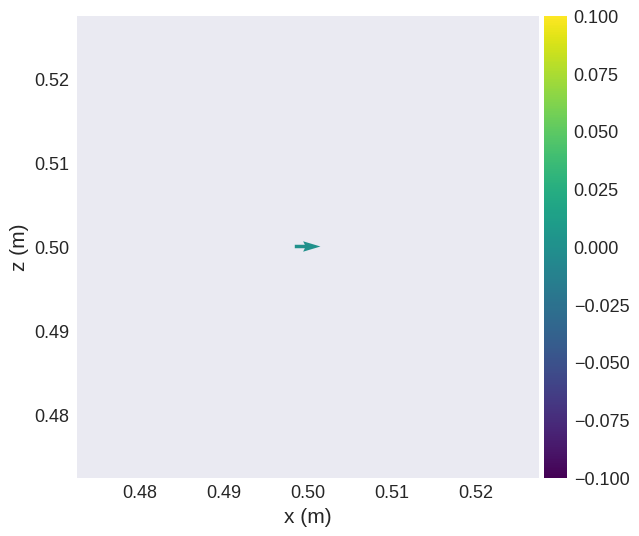

In [2]:
system = mm.System(name='macrospin')
system.energy = mm.Zeeman(H=(0, 0, 5e4))
system.dynamics = mm.Damping(alpha=0.1)
mesh = df.Mesh(p1=(0, 0, 0), p2=(1, 1, 1), n=(1, 1, 1))
system.m = df.Field(mesh, nvdim=3, value=(1, 0, 0), norm=1e4)
system.m.sel('y').mpl.vector()

Running OOMMF (ExeOOMMFRunner)[2023/08/10 16:40]... (0.4 s)


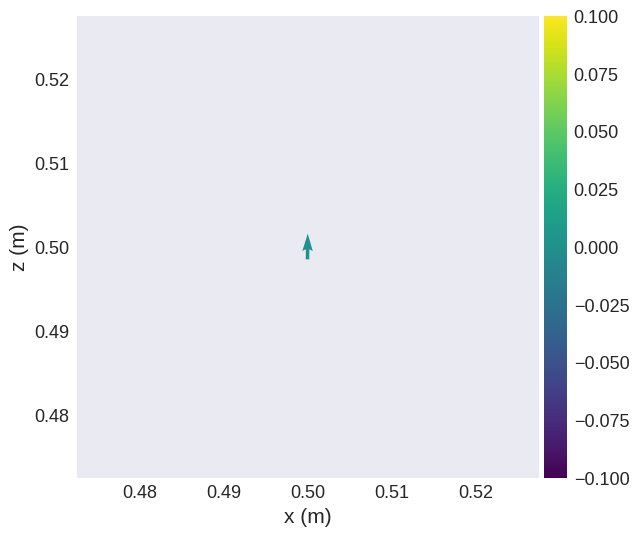

In [3]:
td = mc.TimeDriver()
td.drive(system, t=5e-9, n=100)
system.m.sel('y').mpl.vector()

We can see that the macrospin has rotated by almost ninty degrees. We can plot the time-evolution of the magnetisation:

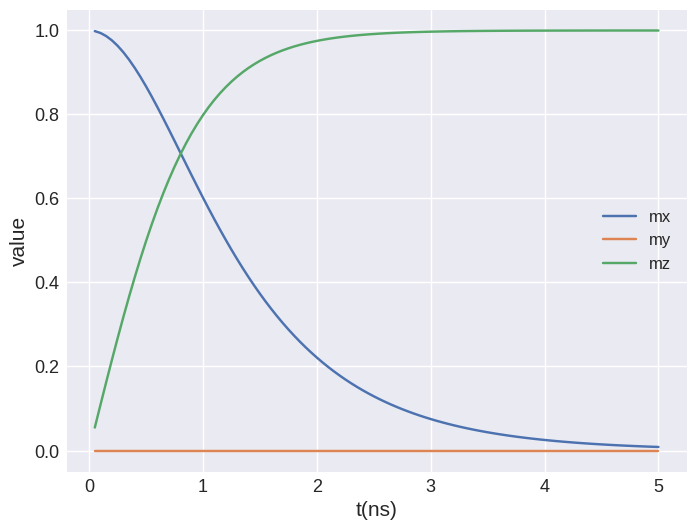

In [4]:
system.table.mpl(y=['mx', 'my', 'mz'])

Now, we create the same system but apply only a shorter pulse with a duration of $2\,\mathrm{ns}$. We still drive the system for $5\,\mathrm{ns}$.

To define this time dependence we have to pass two additional parameters to `mm.Zeeman`. The first one `func` must be a callable must accept a single argument and return a single value (the prefactor at an arbitrary time step given as input argument). The second parameter `dt` defines spacing of the points at which this callable is evaluated. Here, we define a simple step function that returns `1` for the first nanosecond and `0` afterwards.

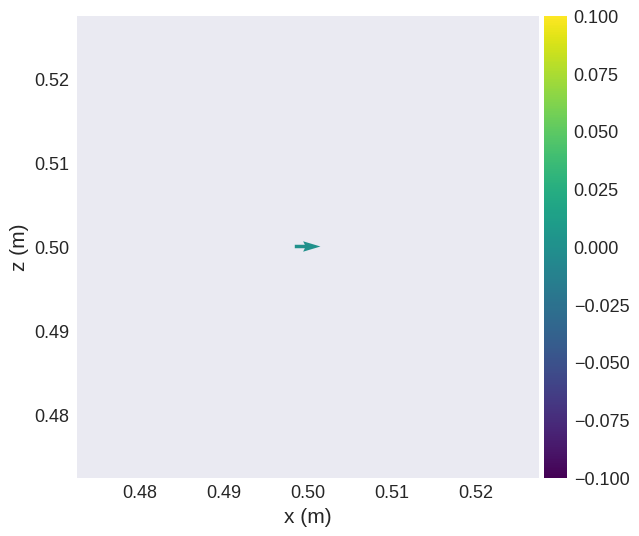

In [5]:
def t_func(t):
    if t < 1e-9:
        return 1
    else:
        return 0

system = mm.System(name='macrospin_pulse')
system.energy = mm.Zeeman(H=(0, 0, 5e4), func=t_func, dt=1e-12)
system.dynamics = mm.Damping(alpha=0.1)
mesh = df.Mesh(p1=(0, 0, 0), p2=(1, 1, 1), n=(1, 1, 1))
system.m = df.Field(mesh, nvdim=3, value=(1, 0, 0), norm=1e4)
system.m.sel('y').mpl.vector()

Running OOMMF (ExeOOMMFRunner)[2023/08/10 16:40]... (0.3 s)


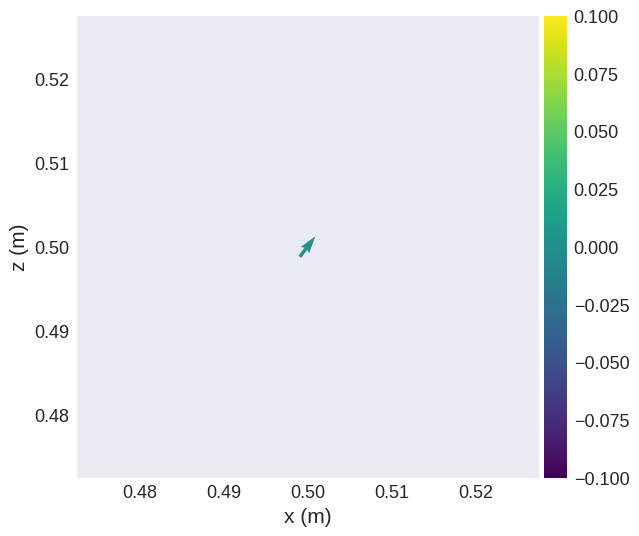

In [6]:
td.drive(system, t=5e-9, n=100)
system.m.sel('y').mpl.vector()

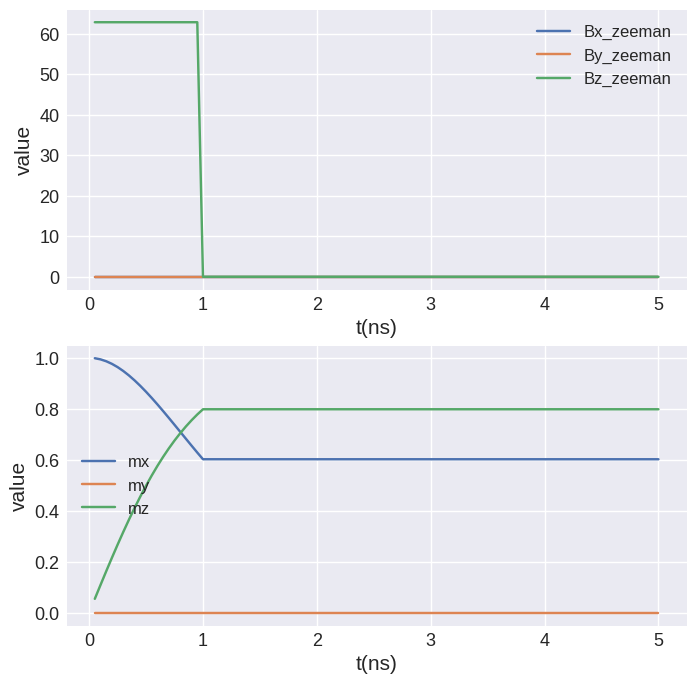

In [7]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 8))
system.table.mpl(ax=ax1, y=['Bx_zeeman', 'By_zeeman', 'Bz_zeeman'])
system.table.mpl(ax=ax2, y=['mx', 'my', 'mz'])

We can see that the macrospin starts to align with the external magnetic field. As the pulse is switched off at $1\,\mathrm{ns}$ the motion stops and the system remains in the current state.

##### How to properly simulate this field pulse

As already mentioned above the field pulse can be simulated without a time-dependent field. We briefly show how to do this. We first apply a constant field and drive the system for $1\,\mathrm{ns}$. Then we remove the field and drive the free system for $4\,\mathrm{ns}$. The main difference is that we end up with two separate runs (and tables).

Running OOMMF (ExeOOMMFRunner)[2023/08/10 16:40]... (0.2 s)


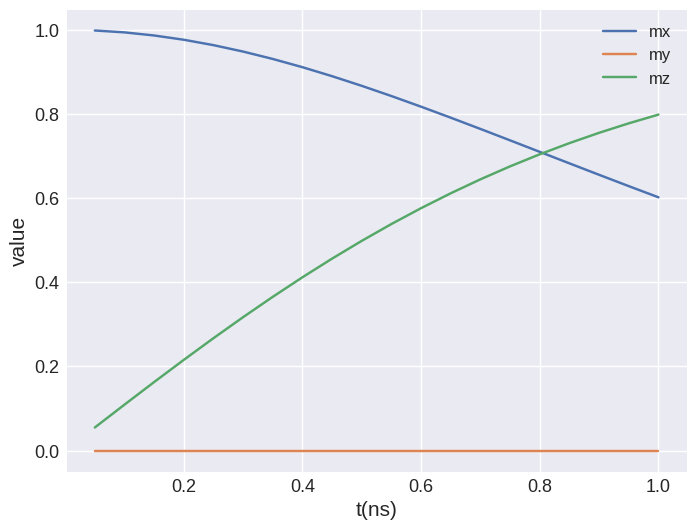

In [8]:
system = mm.System(name='macrospin_pulse_drive')
system.energy = mm.Zeeman(H=(0, 0, 5e4))
system.dynamics = mm.Damping(alpha=0.1)
mesh = df.Mesh(p1=(0, 0, 0), p2=(1, 1, 1), n=(1, 1, 1))
system.m = df.Field(mesh, nvdim=3, value=(1, 0, 0), norm=1e4)

td.drive(system, t=1e-9, n=20)
system.table.mpl(y=['mx', 'my', 'mz'])

Running OOMMF (ExeOOMMFRunner)[2023/08/10 16:40]... (0.2 s)


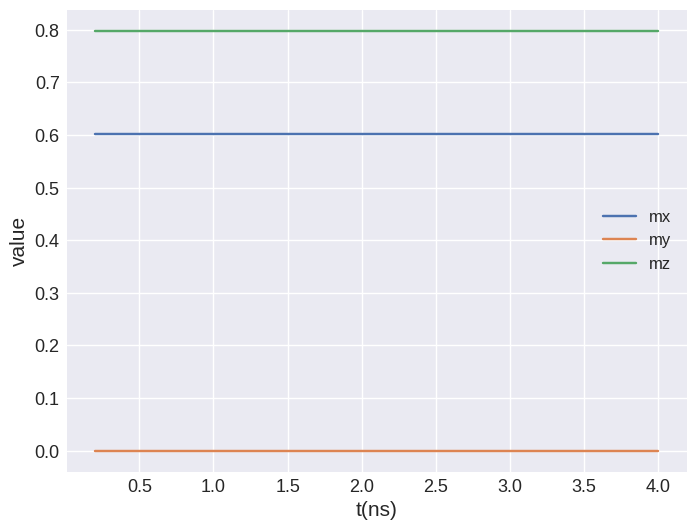

In [9]:
system.energy -= mm.Zeeman(H=(0, 0, 5e4))
td.drive(system, t=4e-9, n=20)
system.table.mpl(y=['mx', 'my', 'mz'])

We can use `micromagneticdata` to combine the two separate runs.

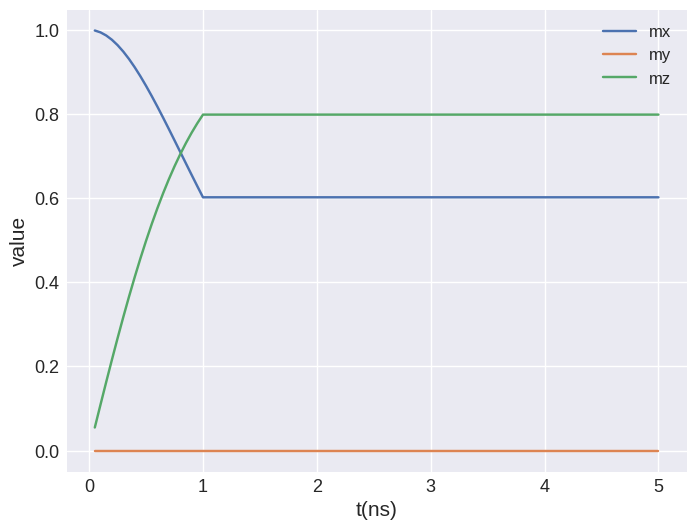

In [10]:
data = micromagneticdata.Data(name='macrospin_pulse_drive')
(data[-2].table << data[-1].table).mpl(y=['mx', 'my', 'mz'])

#### Pre-defined functions

Two of the most commonly used functions, `sin` and `sinc`, are available as pre-defined functions. These can be used as follows (again using the example of a macrospin). The user has to define:

- the `func`tion type (`sin` or `sinc`)
- a frequency `f` in Hz
- optionally an offset `t0` in s

In [11]:
system = mm.System(name='macrospin_sin')
system.energy = mm.Zeeman(H=(0, 1e4, 5e4), func='sin', f=.5e9, t0=0)
system.dynamics = mm.Damping(alpha=0.1)
mesh = df.Mesh(p1=(0, 0, 0), p2=(1, 1, 1), n=(1, 1, 1))
system.m = df.Field(mesh, nvdim=3, value=(1, 0, 0), norm=1e4)
td.drive(system, t=5e-9, n=100)

Running OOMMF (ExeOOMMFRunner)[2023/08/10 16:40]... (0.3 s)


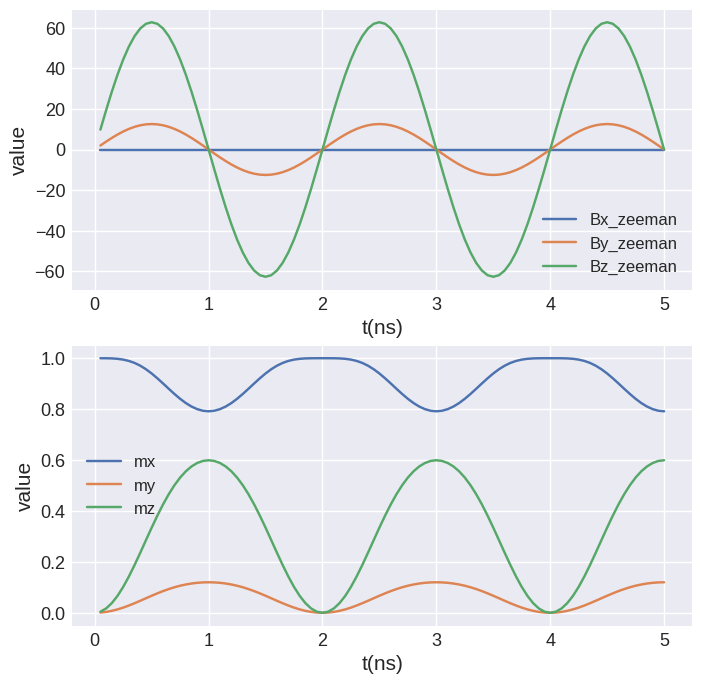

In [12]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 8))
system.table.mpl(ax=ax1, y=['Bx_zeeman', 'By_zeeman', 'Bz_zeeman'])
system.table.mpl(ax=ax2, y=['mx', 'my', 'mz'])

In [13]:
system = mm.System(name='macrospin_sinc')
system.energy = mm.Zeeman(H=(0, 1e4, 5e4), func='sinc', f=1e9, t0=1e-9)
system.dynamics = mm.Damping(alpha=0.1)
mesh = df.Mesh(p1=(0, 0, 0), p2=(1, 1, 1), n=(1, 1, 1))
system.m = df.Field(mesh, nvdim=3, value=(1, 0, 0), norm=1e4)
td.drive(system, t=10e-9, n=200)

Running OOMMF (ExeOOMMFRunner)[2023/08/10 16:40]... (0.4 s)


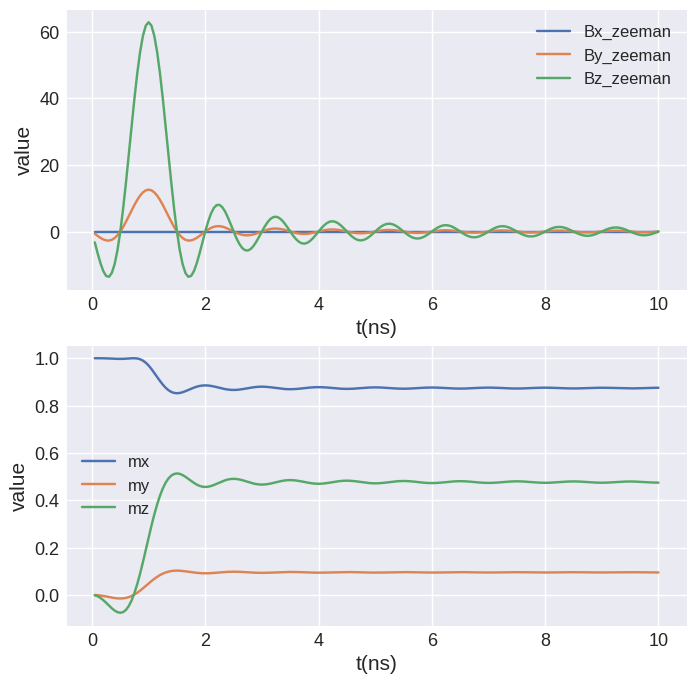

In [14]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 8))
system.table.mpl(ax=ax1, y=['Bx_zeeman', 'By_zeeman', 'Bz_zeeman'])
system.table.mpl(ax=ax2, y=['mx', 'my', 'mz'])

#### Experimentally measured time-dependence

As a third example we assume that we have a list of values (with potentially non-uniform time stepping). This could for example be an experimentally measured time profile. Here, we generate some artifical data, an exponentially decaying sin wave with a constant offset.

_NOTE_: If your data contains noise you should apply some sort of smoothing.

In [15]:
t_sample = np.arange(1001) * 10e-12  # in total 10ns with resolution of 10ps
T = 4e-9
omega = 2 * np.pi / 1e-9  # frequency 1 GHz
np.random.seed(1)
measured_time_dependence = np.exp(-t_sample/T) * np.sin(omega * t_sample) + 0.2  # + np.random.randn(t.size)*.01
measured_time_dependence

array([0.2       , 0.26263374, 0.32470813, ..., 0.18966045, 0.19483294,
       0.2       ])

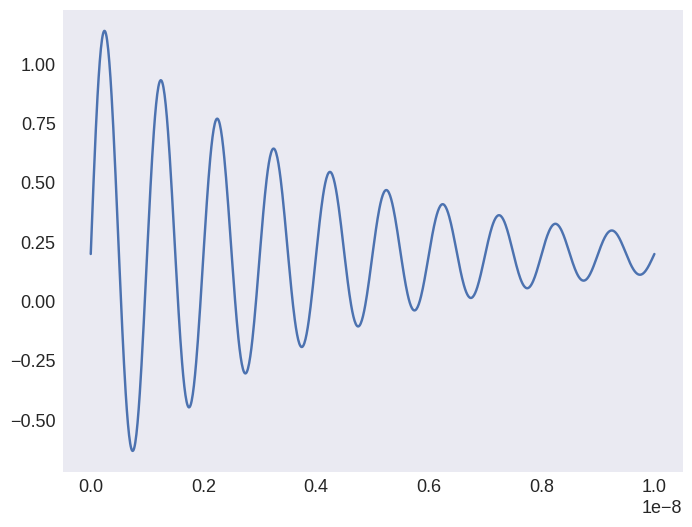

In [16]:
plt.plot(t_sample, measured_time_dependence)

We have to wrap this with a function that returns a single value for an arbitrary timestep. This also allows to handle non-uniform spacing of the (measured) values. In this simple example we assume that we already have equally spaced values. OOMMF is very sensitive to large derivative values. We interpolate between neighbouring values to "improve accuracy" (to decrease derivative values).

In [17]:
def time_dependence(t):
    return np.interp(t, t_sample, measured_time_dependence)

In [18]:
system = mm.System(name='macrospin_measured')
system.energy = mm.Zeeman(H=(0, 0, 5e4), func=time_dependence, dt=1e-13)
system.dynamics = mm.Damping(alpha=0.1)
mesh = df.Mesh(p1=(0, 0, 0), p2=(1, 1, 1), n=(1, 1, 1))
system.m = df.Field(mesh, nvdim=3, value=(1, 0, 0), norm=1e4)
td.drive(system, t=5e-9, n=100)

Running OOMMF (ExeOOMMFRunner)[2023/08/10 16:40]... (0.3 s)


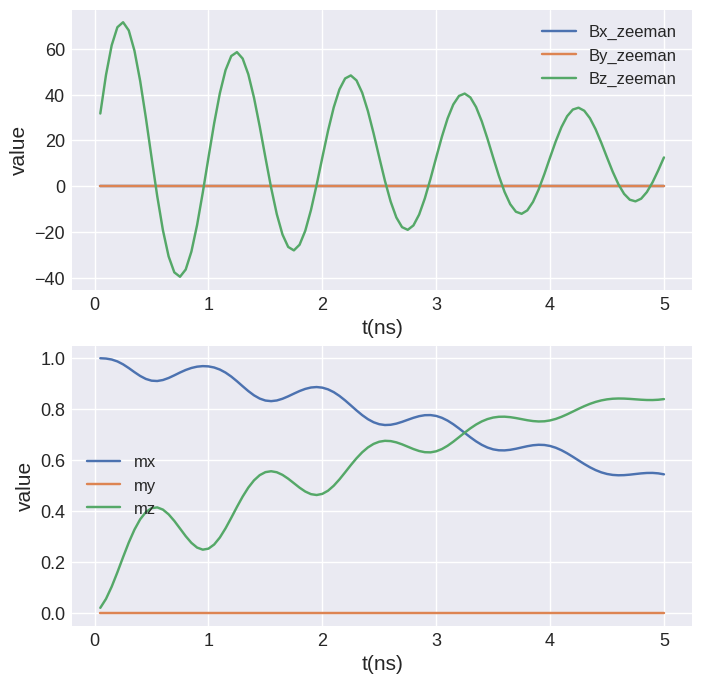

In [19]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 8))
system.table.mpl(ax=ax1, y=['Bx_zeeman', 'By_zeeman', 'Bz_zeeman'])
system.table.mpl(ax=ax2, y=['mx', 'my', 'mz'])

#### Vector

The external magnetic field is a vector quantity and hence cannot only be modulated in amplitude but also rotated over time. Here we demonstrate a rotation in xy-plane (definition of the rotation following an example given on the OOMMF website https://math.nist.gov/oommf/doc/userguide20a2/userguide/Standard_Oxs_Ext_Child_Clas.html#TZ). In the next section we use the same example, but with custom tcl.

In [20]:
system = mm.System(name='rotation')
mesh = df.Mesh(p1=(0, 0, 0), p2=(10, 10, 1), cell=(1, 1, 1))
system.m = df.Field(mesh, nvdim=3, value=(0, 0, 1), norm=1e4)

To define a field rotation the function specifying the time-dependence must return a list of nine values instead of a single one. The elements are the matrix elements of the rotation matrix ($R_{xx}, R_{xy}, R_{xz}, R_{yx}, R_{yy}, R_{yz}, R_{zx}, R_{zy}, R_{zz}$) in this order.

In [21]:
tstep = 1e-13
def rotation(t):
    omega = 2*np.pi * 1e9
    return [np.cos(omega * t), -np.sin(omega * t), 0,
            np.sin(omega * t), np.cos(omega * t), 0,
            0, 0, 1]

We have to define the external magnetic field using a `discretisedfield.Field` object.

In [22]:
H_field = df.Field(mesh, nvdim=3, value=(1,0,0), norm=5e4)

In [23]:
system.energy = (mm.Exchange(A=1e-11)
                 + mm.Demag()
                 + mm.Zeeman(H=H_field, func=rotation, dt=tstep))

In [24]:
system.dynamics = mm.Damping(alpha=.2)

In [25]:
td = mc.TimeDriver()

In [26]:
td.drive(system, t=25e-9, n=1000)

Running OOMMF (ExeOOMMFRunner)[2023/08/10 16:40]... (2.8 s)


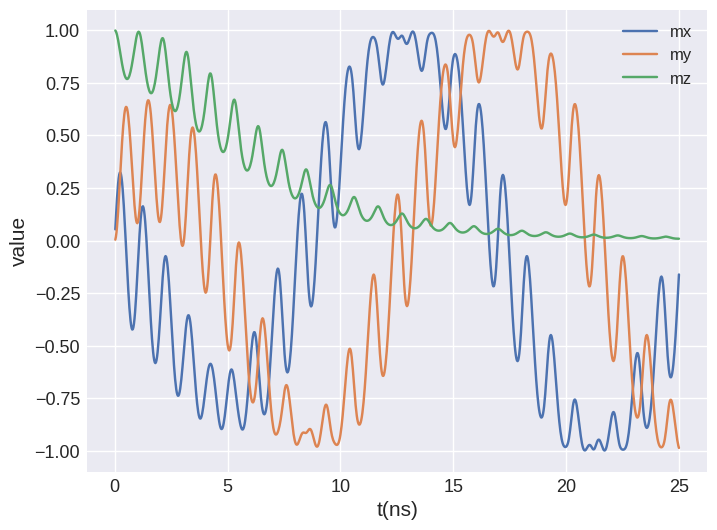

In [27]:
system.table.mpl(y=['mx', 'my', 'mz'])

### Tcl

If the above-presented ways of defining a time-dependence are not enough it is possible to pass several `tcl` strings that are directly forwarded to OOMMF. For any details on available options please refer to the relevant OOMMF documentation and check the generated `mif` file in case of problems or if additional information on certain parameters is required.

To give an example we demonstrate the same rotation in xy-plane as shown in the section above.

In [28]:
system_tcl = mm.System(name='custom_tcl')
mesh = df.Mesh(p1=(0, 0, 0), p2=(10, 10, 1), cell=(1, 1, 1))
system_tcl.m = df.Field(mesh, nvdim=3, value=(0, 0, 1), norm=1e4)

In [29]:
H_field = df.Field(mesh, nvdim=3, value=(1, 0, 0), norm=5e4)

A dictionary `tcl_strings` has to passed to the energy term. It must contain the following keys (details on the OOMMF documentation page https://math.nist.gov/oommf/doc/userguide20a3/userguide/Standard_Oxs_Ext_Child_Clas.html):

- `script`: the script for time-dependence
- `script_args`: arguments passed to the `script`
- `script_name`: name of the `script`
- `type`: transform type (`Oxs_TransformZeeman` only)
- `energy`: class of the energy term (easiest to take from the `mif` file without)

In [30]:
# taken from https://math.nist.gov/oommf/doc/userguide20a2/userguide/Standard_Oxs_Ext_Child_Clas.html#TZ
tcl_strings = {}
tcl_strings['script'] = '''proc TimeFunction { total_time } {
  set PI [expr {4*atan(1.)}]
  set w [expr {1e9*2*$PI}]
  set ct [expr {cos($w*$total_time)}]
  set mct [expr {-1*$ct}]      ;# "mct" is "minus cosine (w)t"
  set st [expr {sin($w*$total_time)}]
  set mst [expr {-1*$st}]      ;# "mst" is "minus sine (w)t"
  return [list  $ct $mst  0 \
                $st $ct   0 \
                  0   0   1 \
                [expr {$w*$mst}] [expr {$w*$mct}] 0 \
                [expr {$w*$ct}]  [expr {$w*$mst}] 0 \
                       0                0         0]
}'''
tcl_strings['energy'] = 'Oxs_TransformZeeman'
tcl_strings['type'] = 'general'
tcl_strings['script_args'] = 'total_time'
tcl_strings['script_name'] = 'TimeFunction'

system_tcl.energy = mm.Exchange(A=1e-11) + mm.Demag() + mm.Zeeman(H=H_field, tcl_strings=tcl_strings)

In [31]:
system_tcl.dynamics = mm.Damping(alpha=.2)

In [32]:
td = mc.TimeDriver()

In [33]:
td.drive(system_tcl, t=25e-9, n=500)

Running OOMMF (ExeOOMMFRunner)[2023/08/10 16:40]... (1.0 s)


In [34]:
system.table.mpl(ax=ax2, y=['mx', 'my', 'mz'])

## Slonczewski and Zhang-Li currents

From the point of view of modelling time-dependent currents both Slonczewski and Zhang-Li behave the same. Examples here use `ZhangLi` but can be directly applied to `Slonczewski`.

### Python function

The callable `time_dependence` must return a single number that is used to multiply the initial values. To demonstrate this we show an example of moving a domain wall with Zhang-Li current.

In [35]:
# Definition of parameters
L = 500e-9  # sample length (m)
w = 20e-9  # sample width (m)
d = 2.5e-9  # discretisation cell size (m)
Ms = 5.8e5  # saturation magnetisation (A/m)
A = 15e-12  # exchange energy constant (J/)
D = 3e-3  # Dzyaloshinkii-Moriya energy constant (J/m**2)
K = 0.5e6  # uniaxial anisotropy constant (J/m**3)
u = (0, 0, 1)  # easy axis
gamma0 = 2.211e5  # gyromagnetic ratio (m/As)
alpha = 0.3  # Gilbert damping

# Mesh definition
p1 = (0, 0, 0)
p2 = (L, w, d)
cell = (d, d, d)
region = df.Region(p1=p1, p2=p2)
mesh = df.Mesh(region=region, cell=cell)

# Micromagnetic system definition
system = mm.System(name='domain_wall')
system.energy = mm.Exchange(A=A) + \
                mm.DMI(D=D, crystalclass='Cnv_z') + \
                mm.UniaxialAnisotropy(K=K, u=u)
system.dynamics = mm.Precession(gamma0=gamma0) + mm.Damping(alpha=alpha)

Because we want to move a DW, we need to initialise the magnetisation in an appropriate way before we relax the system.

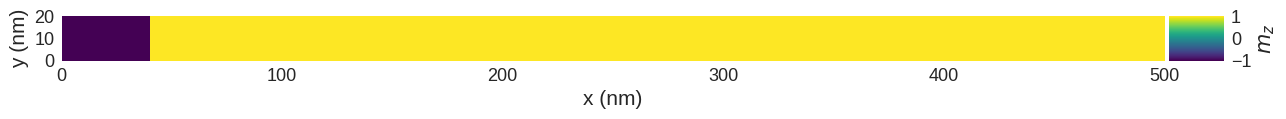

In [36]:
def m_value(pos):
    x, y, z = pos
    if x < 40e-9:
        return (0, 0, -1)
    else:
        return (0, 0, 1)

system.m = df.Field(mesh, nvdim=3, value=m_value, norm=Ms)

system.m.orientation.z.sel('z').mpl.scalar(colorbar_label="$m_z$", figsize=(15, 10))

Now, we can relax the magnetisation.

Running OOMMF (ExeOOMMFRunner)[2023/08/10 16:40]... (1.0 s)


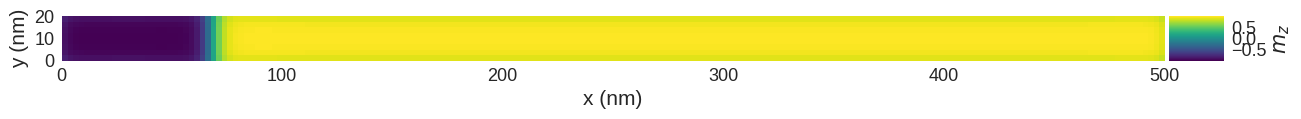

In [37]:
md = mc.MinDriver()
md.drive(system)

system.m.orientation.z.sel('z').mpl.scalar(colorbar_label="$m_z$", figsize=(15, 10))

Now we can add the STT term to the dynamics equation. We define a sinusoidal modulation with period $T=1\,\mathrm{ns}$.

In [38]:
ux = 400  # velocity in x-direction (m/s)
beta = 0.5  # non-adiabatic STT parameter

def time_func(t):
    omega = 2 * np.pi / 1e-9
    return np.sin(omega * t)

system.dynamics += mm.ZhangLi(u=ux, beta=beta, func=time_func, dt=1e-12)

And drive the system for $1.5 \,\text{ns}$ ($1.5T$):

Running OOMMF (ExeOOMMFRunner)[2023/08/10 16:40]... (4.0 s)


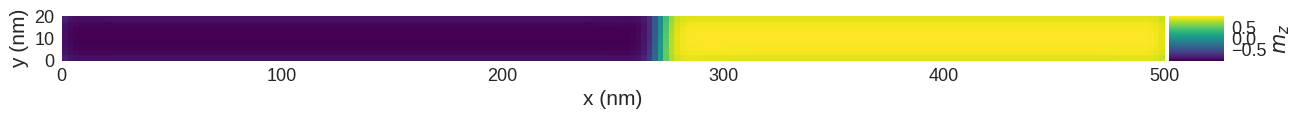

In [39]:
td = mc.TimeDriver()
td.drive(system, t=1.5e-9, n=100)

system.m.orientation.z.sel('z').mpl.scalar(colorbar_label="$m_z$", figsize=(15, 10))

We see that the DW pair has moved to the positive $x$ direction. We can get more information about the movement by plotting the average magnetisation in z-direction as a function of time:

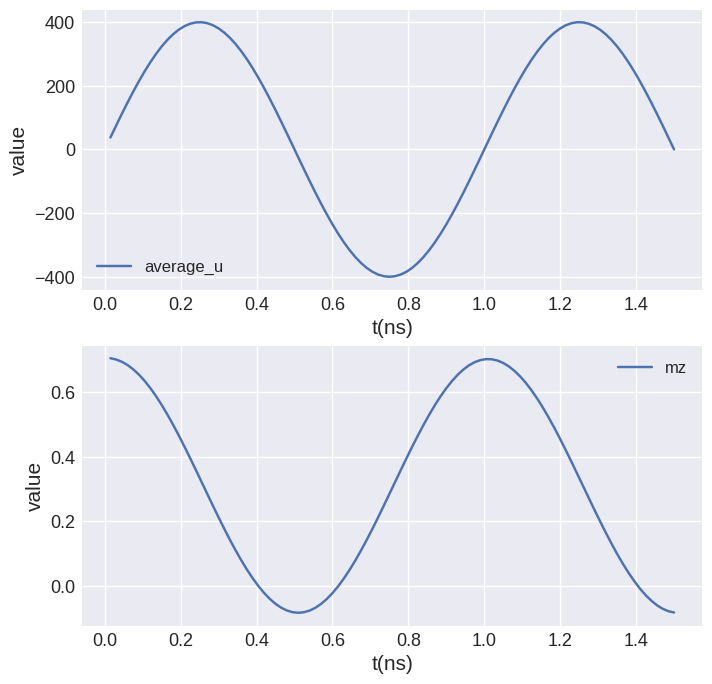

In [40]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 8))
system.table.mpl(ax=ax1, y=['average_u'])
system.table.mpl(ax=ax2, y=['mz'])

We can see that the magnetisation follows the sinusoidal modulation of the current. Now, let us visualise the motion using an interactive plot.

In [41]:
data = micromagneticdata.Data(system.name)

data[1].hv(kdims=["x", "y"])

:DynamicMap   [t]
   :Overlay
      .Image.I       :Image   [x,y]   (field)
      .VectorField.I :VectorField   [x,y]   (angle,mag)

We repeat the same simulation with `Slonczewski` spin current. First we remove the `ZhangLi` term and reset the magnetisation

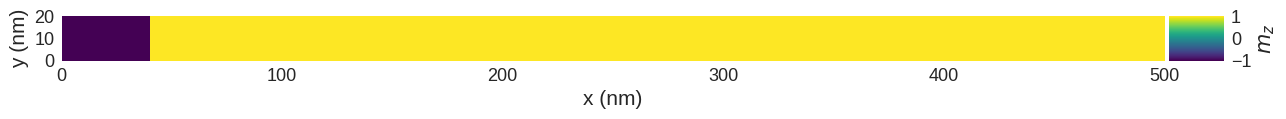

In [42]:
system.dynamics -= mm.ZhangLi(u=ux, beta=beta, func=time_func, dt=1e-12)

def m_value(pos):
    x, y, z = pos
    if x < 40e-9:
        return (0, 0, -1)
    else:
        return (0, 0, 1)

system.m = df.Field(mesh, nvdim=3, value=m_value, norm=Ms)

system.m.orientation.z.sel('z').mpl.scalar(colorbar_label="$m_z$", figsize=(15, 10))

Now, we can relax the magnetisation.

Running OOMMF (ExeOOMMFRunner)[2023/08/10 16:40]... (1.0 s)


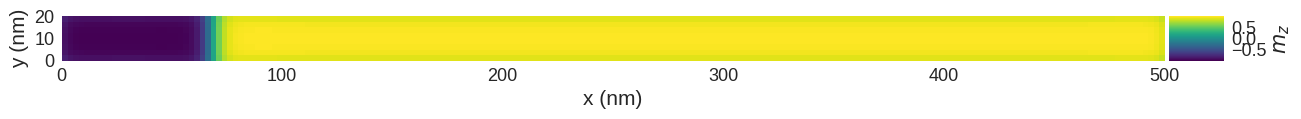

In [43]:
md = mc.MinDriver()
md.drive(system)

system.m.orientation.z.sel('z').mpl.scalar(colorbar_label="$m_z$", figsize=(15, 10))

Then, we add the `Slonczewski` term.

In [44]:
J = 2e12
mp = (0, 0, -1)
P = 0.8
Lambda = 1

def time_func(t):
    omega = 2 * np.pi / 1e-9
    return np.sin(omega * t)

system.dynamics += mm.Slonczewski(J=J, mp=mp, P=P, Lambda=Lambda, func=time_func, dt=1e-12)

And drive the system for $1.5 \,\text{ns}$ ($1.5T$):

Running OOMMF (ExeOOMMFRunner)[2023/08/10 16:40]... (4.3 s)


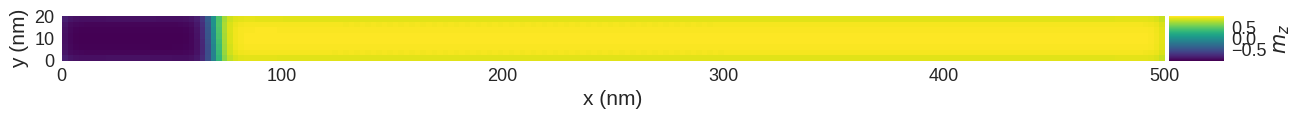

In [45]:
td = mc.TimeDriver()
td.drive(system, t=1.5e-9, n=100)

system.m.orientation.z.sel('z').mpl.scalar(colorbar_label="$m_z$", figsize=(15, 10))

We can get more information about the movement by plotting the average magnetisation in z-direction as a function of time:

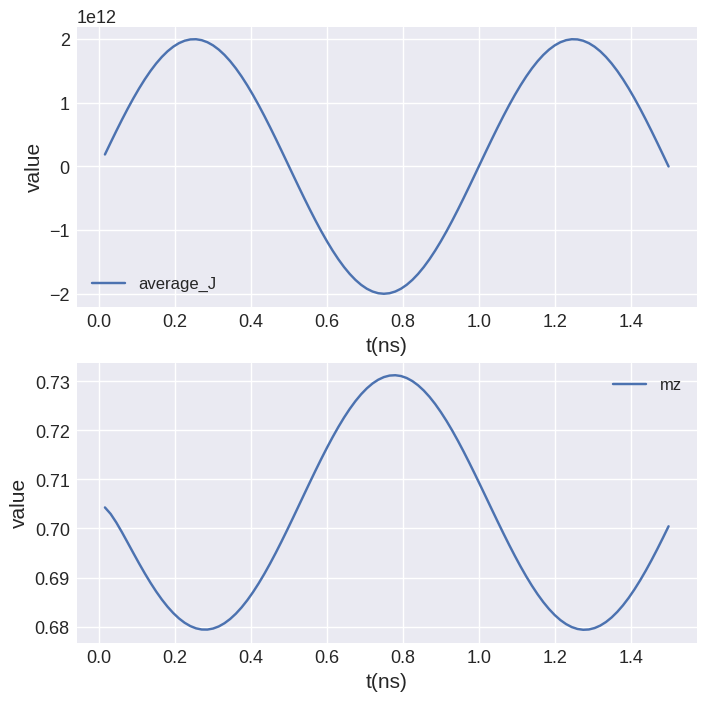

In [46]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 8))
system.table.mpl(ax=ax1, y=['average_J'])
system.table.mpl(ax=ax2, y=['mz'])

We can see that the magnetisation follows the sinusoidal modulation of the current. Now, let us visualise the motion using an interactive plot.

In [47]:
data = micromagneticdata.Data(system.name)

data[1].hv(kdims=["x", "y"])

:DynamicMap   [t]
   :Overlay
      .Image.I       :Image   [x,y]   (field)
      .VectorField.I :VectorField   [x,y]   (angle,mag)

### Tcl

Custom `tcl` can be passed similar to the Zeeman field. The dictionary `tcl_strings` has to be passed to the energy term. It must contain the following keys (details on the OOMMF documentation pages):

- `script`: the script for time-dependence
- `script_args`: arguments passed to the `script`
- `script_name`: name of the `script`